<a href="https://colab.research.google.com/github/alouwyck/vives-deep-learning/blob/main/topic12/chapter12_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

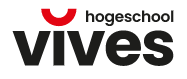<br>


**DEEP LEARNING**<br>
Academiejaar 2023-2024<br>
Andy Louwyck

---



---



# 12. Generative Deep Learning: Part I

Voorbeelden uit het eerste deel van hoofdstuk 12 van het boek "Deep Learning with Python" (2e editie) van François Chollet. Dit deel gaat over **text generation**.

De originele notebook gebruikt TensorFlow 2.6.

## 12.1. Text generation

### 12.1.3. The importance of the sampling strategy

**Reweighting a probability distribution to a different temperature**

In [ ]:
import numpy as np

def reweight_distribution(original_distribution, temperature=0.5):
    distribution = np.log(original_distribution) / temperature
    distribution = np.exp(distribution)
    return distribution / np.sum(distribution)

### 12.1.4. Implementing text generation with Keras

#### Preparing the data

**Downloading and uncompressing the IMDB movie reviews dataset**

In [ ]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

--2023-12-05 20:03:40--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  9.18MB/s    in 13s     

2023-12-05 20:03:53 (6.34 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



**Creating a dataset from text files (one file = one sample)**

In [ ]:
import tensorflow as tf
from tensorflow import keras

dataset = keras.utils.text_dataset_from_directory(directory="aclImdb", label_mode=None, batch_size=256)
dataset = dataset.map(lambda x: tf.strings.regex_replace(x, "<br />", " "))

Found 100006 files belonging to 1 classes.


**Preparing a `TextVectorization` layer**

In [ ]:
from keras.layers import TextVectorization

# We’ll work with inputs and targets of length 100
# but since we’ll offset the targets by 1, the model will actually see sequences of length 99
sequence_length = 100

# We’ll only consider the top 15000 most common words
# anything else will be treated as the out-of-vocabulary token, "[UNK]"
vocab_size = 15000

text_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",  # We want to return integer word index sequences
    output_sequence_length=sequence_length,
)
text_vectorization.adapt(dataset)  # creating the vocabulary

**Setting up a language modeling dataset**

In [ ]:
def prepare_lm_dataset(text_batch):
    # Convert a batch of texts (strings) to a batch of integer sequences
    vectorized_sequences = text_vectorization(text_batch)
    # Create inputs by cutting off the last word of the sequences
    x = vectorized_sequences[:, :-1]
    # Create targets by offsetting the sequences by 1
    y = vectorized_sequences[:, 1:]
    return x, y

lm_dataset = dataset.map(prepare_lm_dataset, num_parallel_calls=4)

#### A Transformer-based sequence-to-sequence model

See chapter 11

In [ ]:
import tensorflow as tf
from keras import layers

In [ ]:
class PositionalEmbedding(layers.Layer):

    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

In [ ]:
class TransformerDecoder(layers.Layer):

    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
          num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(
          num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):
        config = super(TransformerDecoder, self).get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        else:
            padding_mask = mask
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)

**A simple Transformer-based language model**

In [ ]:
embed_dim = 256
latent_dim = 2048
num_heads = 2

inputs = keras.Input(shape=(None,), dtype="int64")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, x)
# softmax over possible vocabulary words, computed for each output sequence timestep
outputs = layers.Dense(vocab_size, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop")

### 12.1.5. A text-generation callback with variable-temperature sampling

**The text-generation callback**

In [ ]:
import numpy as np

# dict that maps word indices back to strings, to be used for text decoding
tokens_index = dict(enumerate(text_vectorization.get_vocabulary()))

# Implements variable temperature sampling from a probability distribution
def sample_next(predictions, temperature=1.0):
    predictions = np.asarray(predictions).astype("float64")
    predictions = np.log(predictions) / temperature
    exp_preds = np.exp(predictions)
    predictions = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, predictions, 1)
    return np.argmax(probas)

In [ ]:
class TextGenerator(keras.callbacks.Callback):

    def __init__(self,
                 prompt,  # Prompt that we use to seed text generation
                 generate_length,  # How many words to generate
                 model_input_length,
                 temperatures=(1.,),  # Range of temperatures to use for sampling
                 print_freq=1):
        self.prompt = prompt
        self.generate_length = generate_length
        self.model_input_length = model_input_length
        self.temperatures = temperatures
        self.print_freq = print_freq
        vectorized_prompt = text_vectorization([prompt])[0].numpy()
        self.prompt_length = np.nonzero(vectorized_prompt == 0)[0][0]

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.print_freq != 0:
            return
        for temperature in self.temperatures:
            print("== Generating with temperature", temperature)
            # When generating text, we start from our prompt
            sentence = self.prompt
            for i in range(self.generate_length):
                # Feed the current sequence into our model
                tokenized_sentence = text_vectorization([sentence])
                predictions = self.model(tokenized_sentence)
                # Retrieve the predictions for the last timestep, and use them to sample a new word
                next_token = sample_next(
                    predictions[0, self.prompt_length - 1 + i, :]
                )
                sampled_token = tokens_index[next_token]
                # Append the new word to the current sequence and repeat
                sentence += " " + sampled_token
            print(sentence)

We’ll use a diverse range of temperatures to sample text, to demonstrate the effect of temperature on text generation:


In [ ]:
prompt = "This movie"
text_gen_callback = TextGenerator(
    prompt,
    generate_length=50,
    model_input_length=sequence_length,
    temperatures=(0.2, 0.5, 0.7, 1., 1.5))

**Fitting the language model**

Let’s `fit` this thing:

In [ ]:
model.fit(lm_dataset, epochs=200, callbacks=[text_gen_callback])

---